In [25]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
import xml.etree.ElementTree as ET
import pprint
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from IPython.display import Image, display
%matplotlib inline

"""Parsing the Play""" 
def parsePlay(title):
    
    tree = ET.parse(title)
    root = tree.getroot()
    
    dialogs = {}
    line_number = 0
    
    acts = root.findall("ACT")
    for act in acts:
        scenes = act.findall("SCENE")
        for scene in scenes:
            speeches = scene.findall("SPEECH")
            for speech in speeches:
                characters = speech.findall("SPEAKER")
                for character in characters:
                    dialog_line = "\n".join([s.text for s in speech.findall("LINE") if s.text])
                    if character.text not in dialogs.keys():
                        dialogs[character.text] = []
                    if len(dialog_line) > 0:
                        dialogs[character.text].append((line_number,dialog_line))
                        line_number += 1
    
    for character in dialogs.keys():
            if len(dialogs[character]) < 2:
                del dialogs[character]
    return dialogs

def merge_two_dicts(x, y):
    '''Given two dicts, merge them into a new dict as a shallow copy.'''
    z = x.copy()
    z.update(y)
    return z


def getAllTopChars(max_chars=5, dir="./shaks200"):
    chars = {}
    for file in os.listdir(dir):
        if file.endswith(".xml"):
            dialog = parsePlay(dir + '/' + file)
            d = sorted(dialog.items(), key=lambda x: len(x[1]), reverse=True)
            if len(d) > max_chars:
                d = d[:max_chars]
            for i in range(len(d)):
                d[i] = (file[:-4] + d[i][0], d[i][1]) #prepend play name to character name
            chars = merge_two_dicts(chars, dict(d))

    return chars

"""Scaling the values"""
def rescaleTime(dialogs):
    
    time_scaled_dialogs = {}
    
    for character in dialogs.keys():
        abs_lines, speeches = zip(*dialogs[character])
        first_line = min(abs_lines)
        last_line = max(abs_lines)
        scaled_lines = map(lambda x: (x - float(first_line))/(last_line - first_line), abs_lines)  
        time_scaled_dialogs[character] = zip(scaled_lines, speeches)
    
    return time_scaled_dialogs

"""Sentiment Analysis"""
sid = SentimentIntensityAnalyzer()

#Scoring functions
def diff(line):
    ss = sid.polarity_scores(line)
    tot = 0
    for k in sorted(ss):
        if(k=='neg'):
            tot = tot - ss[k]
        elif(k=='pos'):
            tot = tot + ss[k]
    return tot

def total(line):
    ss = sid.polarity_scores(line)
    ntot = 0
    ptot = 0
    for k in sorted(ss):
        if(k=='neg'):
            ntot = ntot + ss[k]
        elif(k=='pos'):
            ptot = ptot + ss[k]
    return ntot+ptot

def ratio(line):
    ss = sid.polarity_scores(line)
    ntot = 0
    ptot = 0
    for k in sorted(ss):
        if(k=='neg'):
            ntot = ntot + ss[k]
        elif(k=='pos'):
            ptot = ptot + ss[k]
    if(ptot==0 and ntot==0):
        return 0
    elif(ptot==0):
        return ptot/ntot
    elif(ntot==0):
        return ntot/ptot
    else:
        return ptot/ntot

#function to iterate through dictionary 
def turn_lines_to_score(char_dict, score_func="diff"):
    new_dict = {}
    for (ch,line) in char_dict:#.items():
        new_dict[ch] = []
        for n, l in line:
            if(score_func=="diff"):
                score = diff(l)
                new_dict[ch].append((n, score))
            elif(score_func=="tot"):
                score = total(l)
                new_dict[ch].append((n,score))
            elif(score_func=="rat"):
                score = ratio(l)
                new_dict[ch].append((n,score))     
    return new_dict

def interpolate_points(function_points, interp_x):
    """
    Linearly interpolates y values between points for given x values

    :param function_points: list of points which define the function whose range is [a,b]
    :param interp_x: list of x points for which you want to get interpolated values
    :returns list of (x, y) points for interp_x values
    """
    fcn_sorted = sorted(function_points, key=lambda point: point[0])
    print fcn_sorted
    xp, yp = zip(*fcn_sorted)
    print xp
    print yp
    return zip(interp_x, np.interp(interp_x, xp, yp))

def test():
    points = [(0,0), (2,0), (4,2), (6, -2)]
    interps = [0, 1, 3, 5]
    expected_y = [0, 0, 1, 0]

    x2, y2 = zip(*interpolate_points(points, interps))

    print "The two following arrays should be equal:\n" + str(expected_y) + \
          "\n" + str(y2)

#test()

def bar(dict):
    x = []
    y = []
    z = []
    for i in range(len(scaled)):
        x.append(i)
    
    for (ch, l) in scaled.items():
        z.append(ch)
        y.append(len(l))
    plt.bar(x,y)
    plt.xticks(x, z, rotation=90)
    plt.show()

#make fucntion that graphs  two charcater sentiments
def compare(l1, l2):
    x = []
    for i in range(len(l1)):
        x.append(i)
    plt.plot(x,l1)
    plt.plot(x,l2,'r')
    plt.show()
    
display(Image(filename='C:\Users\sundar d\Desktop\Final Project\Outline.png',width=400))


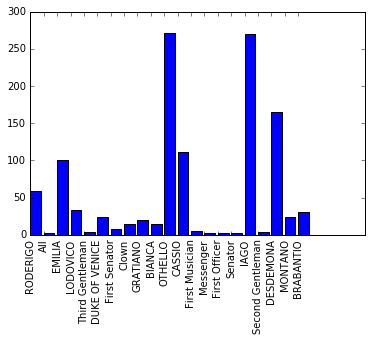

In [7]:
pp = pprint.PrettyPrinter(indent=4)
dialogs = parsePlay('C:\Users\sundar d\Desktop\Final Project\shaks200\othello.xml')
#print dialogs['HAMLET']

d = sorted(dialogs.items(), key=lambda x: len(x[1]), reverse=True)
#print d[0][1][0] #first line from hamlet 

scored = turn_lines_to_score(d, score_func="diff")
#print scored

scaled = rescaleTime(scored)
#print len(scaled) #number of characters 
#print len(scaled['OTHELLO']) #number of lines given character

bar(scaled)


The above graph shows the number of lines each character in othello has.

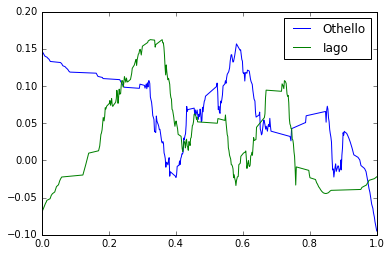

In [8]:
x1 = []
l1 = []
for x in range(len(scaled['OTHELLO'])):
    x1.append(scaled['OTHELLO'][x][0])    
    l1.append(scaled['OTHELLO'][x][1])
    

x2 = []
l2 = []
for y in range(len(scaled['IAGO'])):
    x2.append(scaled['IAGO'][y][0])
    l2.append(scaled['IAGO'][y][1])

l1h = savgol_filter(l1, 71, 2)
l2h = savgol_filter(l2, 71, 2)

#plt.plot(x1,l1, label="Noisy Othello")
#plt.plot(x2,l2, label="Noisy Iago")
plt.plot(x1,l1h, label="Othello")
plt.plot(x2,l2h, label="Iago")
plt.legend()
plt.show()

#compare(l1,l2)